In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import pylab as py
import warnings
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sqlalchemy import create_engine
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# Do data cleaning, exploratory data analysis, and feature engineering make sure that your work is satisfactory.

In [3]:
house_prices_df.info()
house_prices_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

(1460, 81)

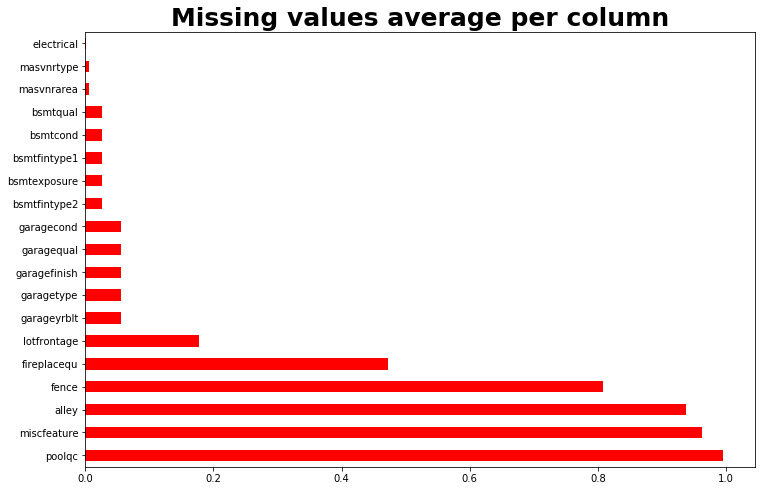

In [4]:
allna = (house_prices_df.isnull().sum() / len(house_prices_df))
allna = allna.drop(allna[allna == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
allna.plot.barh(color='red')
plt.title('Missing values average per column', fontsize=25, weight='bold' )
plt.show()

In [5]:
#delete some features with very high number of missing values.  
house_prices_df.drop(["poolqc","alley","fence","id","miscfeature"],axis=1,inplace=True)

columns that have over half of data missing I decide to drop because it does not make sense to fill in over half the data.

In [6]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 39


Above is are all columns that have texts as values

In [7]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 37


Above are all columns that have numbers as values

In [8]:
total = house_prices_df.isnull().sum().sort_values(ascending=False)
percent = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
fireplacequ,690,0.473
lotfrontage,259,0.177
garagecond,81,0.055
garagetype,81,0.055
garageyrblt,81,0.055
garagefinish,81,0.055
garagequal,81,0.055
bsmtexposure,38,0.026
bsmtfintype2,38,0.026
bsmtfintype1,37,0.025


In [9]:
house_prices_df

,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,60,RL,65.000,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85.000,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75.000,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,nan,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51.000,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50.000,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


In [10]:
house_prices_df.nunique()

mssubclass         15
mszoning            5
lotfrontage       110
lotarea          1073
street              2
lotshape            4
landcontour         4
utilities           2
lotconfig           5
landslope           3
neighborhood       25
condition1          9
condition2          8
bldgtype            5
housestyle          8
overallqual        10
overallcond         9
yearbuilt         112
yearremodadd       61
roofstyle           6
roofmatl            8
exterior1st        15
exterior2nd        16
masvnrtype          4
masvnrarea        327
exterqual           4
extercond           5
foundation          6
bsmtqual            4
bsmtcond            4
                 ... 
bsmthalfbath        3
fullbath            4
halfbath            3
bedroomabvgr        8
kitchenabvgr        4
kitchenqual         4
totrmsabvgrd       12
functional          7
fireplaces          4
fireplacequ         5
garagetype          6
garageyrblt        97
garagefinish        3
garagecars          5
garagearea

In [11]:
numeric_columns = house_prices_df[['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2',
       'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces',
       'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval',
       'mosold', 'yrsold', 'saleprice']]
for col in numeric_columns:
    house_prices_df.loc[:, col] = house_prices_df.loc[:, col].fillna(house_prices_df.loc[:, col].mean())

Above we selected all the numeric columns and filled in missing columns using the mean.

In [12]:
house_prices_df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,42.301,22.024,9981.265,1.383,1.113,30.203,20.645,180.569,456.098,161.319,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,20.000,60.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,50.000,70.050,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,70.000,79.000,11601.500,7.000,6.000,2000.000,2004.000,164.250,712.250,0.000,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


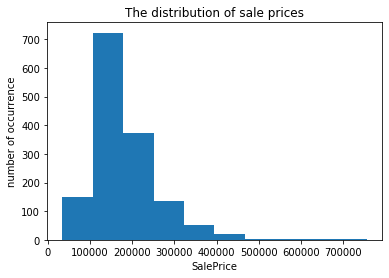

In [13]:
plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("SalePrice")
plt.ylabel("number of occurrence")
plt.show()

(array([0.5]), <a list of 1 Text yticklabel objects>)

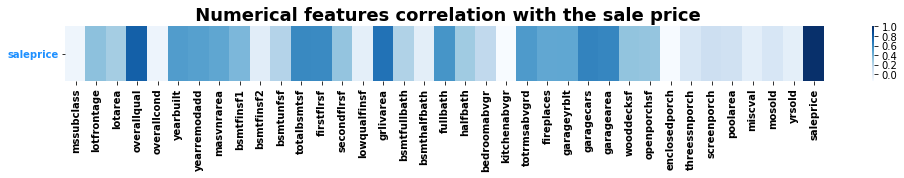

In [14]:
num=house_prices_df.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['saleprice'], ascending=False).head(1), cmap='Blues')
plt.title(" Numerical features correlation with the sale price", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

Above we display all numerical features correlated with sale price. We see saleprice is the darkest blue. Colors that are close to it or similar means correlation is high we will potentially use it.

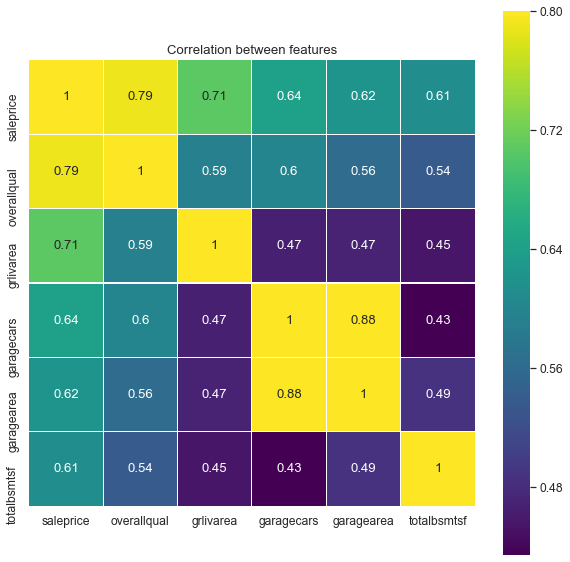

In [15]:
corrMatrix=house_prices_df[['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf']].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features');

As we saw above there are few feature which shows high multicollinearity from heatmap. Lets focus on yellow squares on diagonal line and few on the sides.

SalePrice and OverallQual

GarageArea and GarageCars

TotalBsmtSF and 1stFlrSF

GrLiveArea and TotRmsAbvGrd

YearBulit and GarageYrBlt

We have to create a single feature from them before we use them as predictors.

The below graphs shows correlation from numeric features we selected and compared them to our target variable(saleprice) to visualize the correlation.

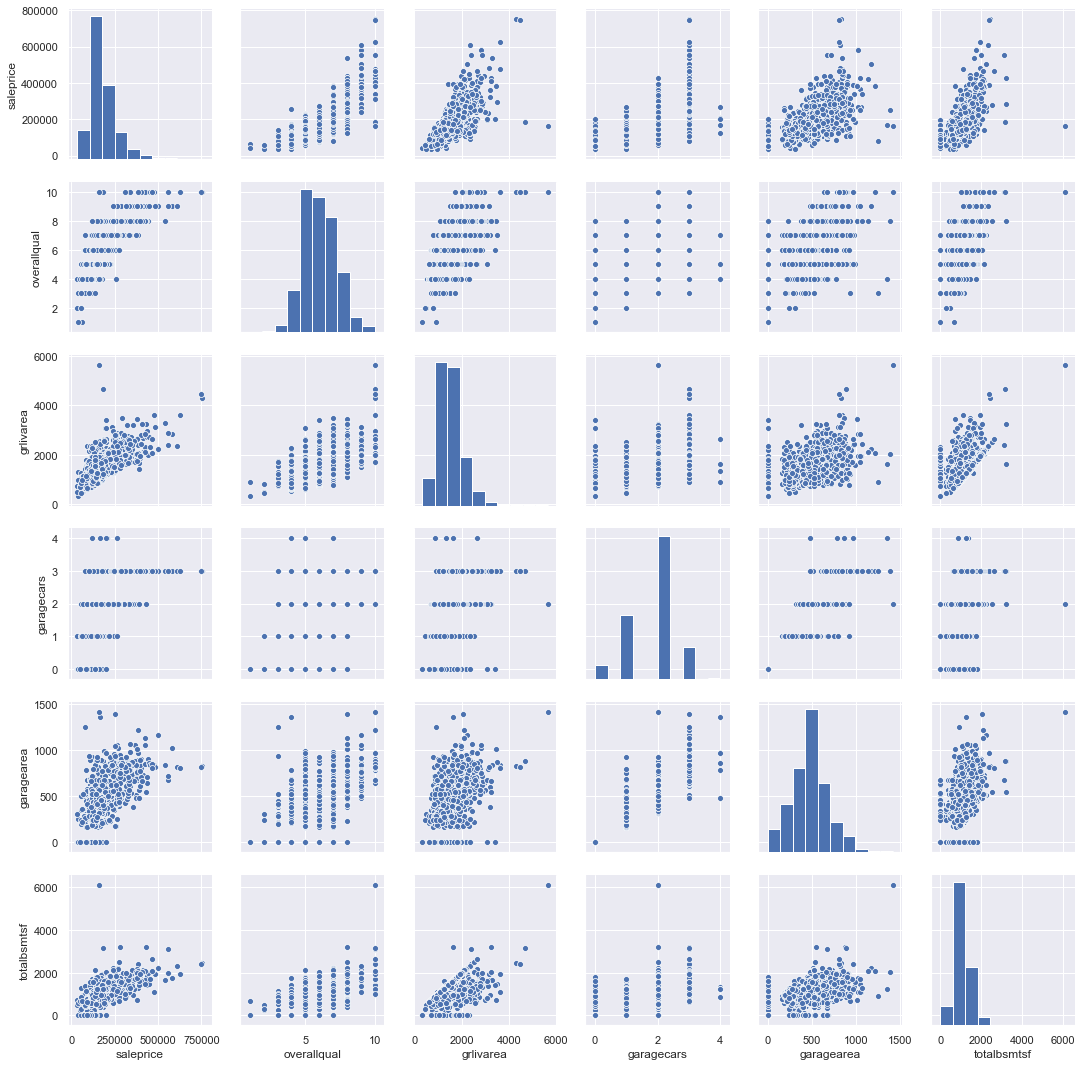

In [16]:
sns.set()
cols = ['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf']
sns.pairplot(house_prices_df[cols], size = 2.5)
plt.show();

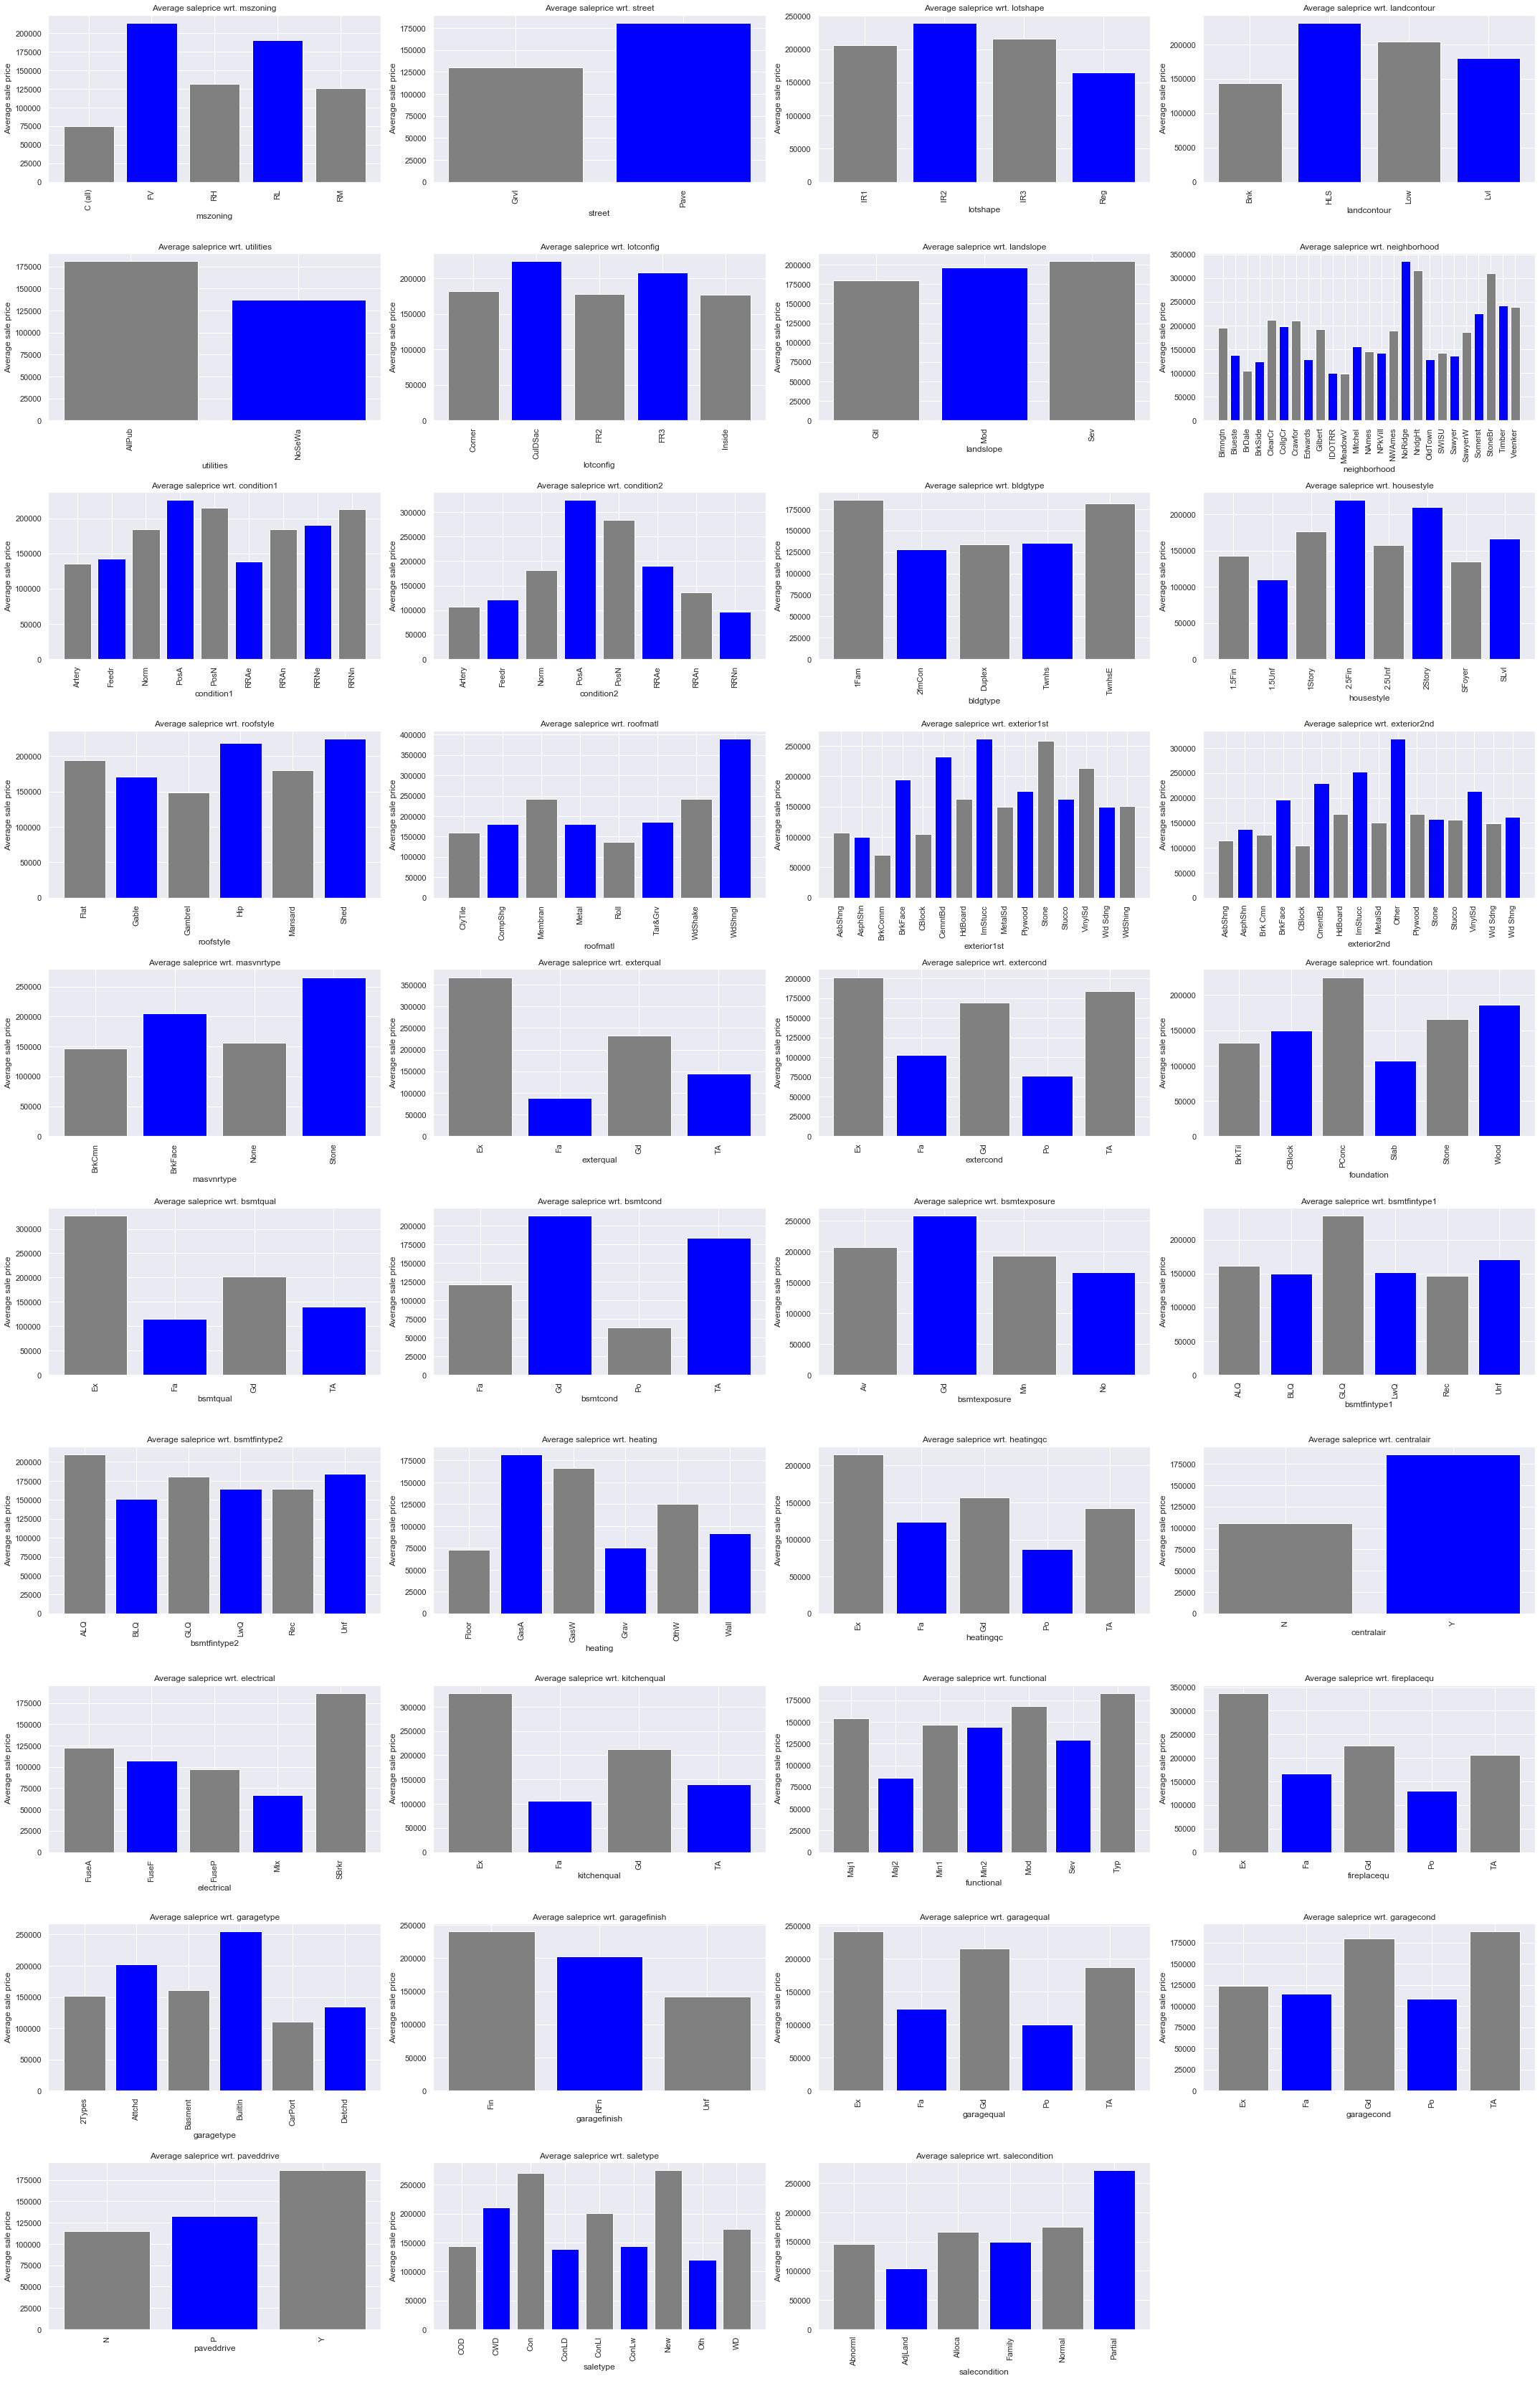

In [17]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),
           color=("grey","blue"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In the graphs above we display correolation between non numeric columns to our target variable which is saleprice.

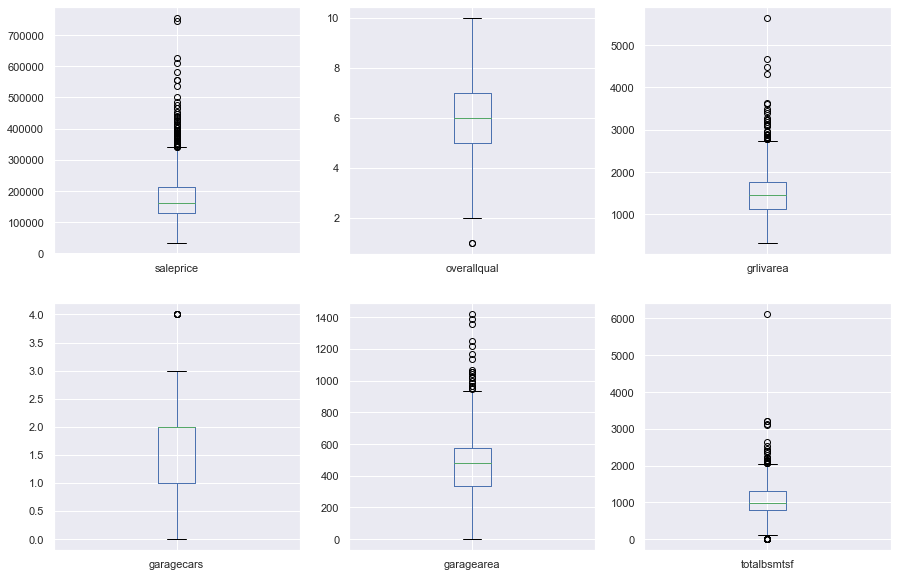

In [18]:
plt.figure(figsize=(15,10))
for i, col in enumerate(["saleprice","overallqual", "grlivarea",
                         "garagecars", "garagearea", "totalbsmtsf"], start=1):
    plt.subplot(2, 3, i)
    house_prices_df.boxplot(col)

In [20]:
from scipy.stats.mstats import winsorize
winsorize_sale_price = winsorize(house_prices_df["saleprice"],(0, 0.10))
winsorize_overall_qual = winsorize(house_prices_df["overallqual"],(0, 0.10))
winsorize_grlivarea = winsorize(house_prices_df["grlivarea"],(0, 0.10))
winsorize_garage_cars = winsorize(house_prices_df["garagecars"],(0, 0.10))
winsorize_garage_area = winsorize(house_prices_df["garagearea"],(0, 0.10))
winsorize_total_bsmtsf = winsorize(house_prices_df["totalbsmtsf"],(0, 0.10))


winsorize_sale_price, winsorize_overall_qual, winsorize_grlivarea, winsorize_garage_cars,winsorize_garage_area, winsorize_total_bsmtsf

(masked_array(data=[208500, 181500, 223500, ..., 266500, 142125, 147500],
              mask=False,
        fill_value=999999), masked_array(data=[7, 6, 7, ..., 7, 5, 5],
              mask=False,
        fill_value=999999), masked_array(data=[1710, 1262, 1786, ..., 2158, 1078, 1256],
              mask=False,
        fill_value=999999), masked_array(data=[2, 2, 2, ..., 1, 1, 1],
              mask=False,
        fill_value=999999), masked_array(data=[548, 460, 608, ..., 252, 240, 276],
              mask=False,
        fill_value=999999), masked_array(data=[ 856, 1262,  920, ..., 1152, 1078, 1256],
              mask=False,
        fill_value=999999))

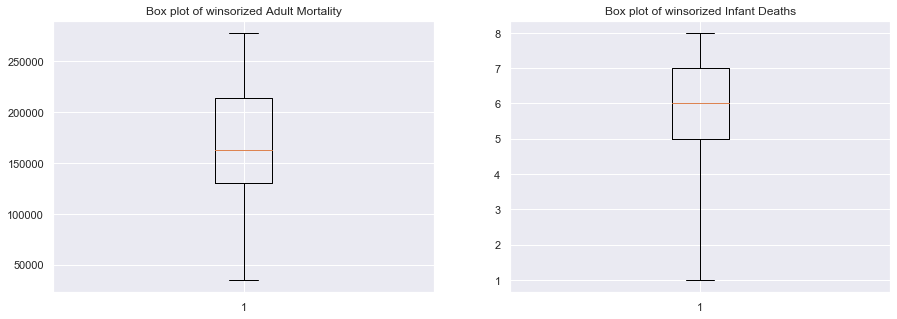

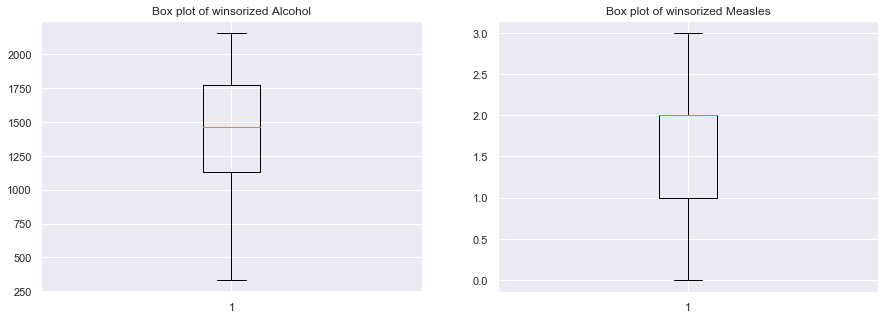

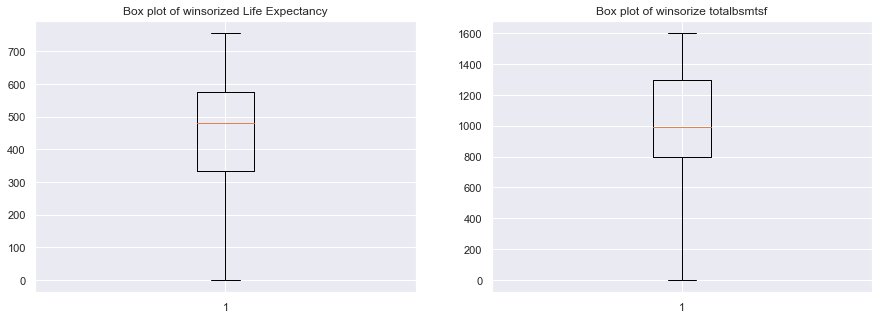

In [21]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(winsorize_sale_price, whis = 5)
plt.title("Box plot of winsorized Adult Mortality")

plt.subplot(1,2,2)
plt.boxplot(winsorize_overall_qual, whis = 5)
plt.title("Box plot of winsorized Infant Deaths")
plt.show()


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(winsorize_grlivarea, whis = 5)
plt.title("Box plot of winsorized Alcohol")

plt.subplot(1,2,2)
plt.boxplot(winsorize_garage_cars, whis = 5)
plt.title("Box plot of winsorized Measles")
plt.show()


plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.boxplot(winsorize_garage_area, whis = 5)
plt.title("Box plot of winsorized Life Expectancy")

plt.subplot(1,2,2)
plt.boxplot(winsorize_total_bsmtsf, whis = 5)
plt.title("Box plot of winsorize totalbsmtsf")
plt.show()

Above we use winsorize to reduce outliers in our target and feature variable. This way we can have clean target and feature variables to work with.

In [22]:
house_prices_df[["saleprice", "overallqual", "grlivarea",
              "garagecars", "garagearea", "totalbsmtsf", "lotconfig"]].corr()

,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf
saleprice,1.000,0.791,0.709,0.640,0.623,0.614
overallqual,0.791,1.000,0.593,0.601,0.562,0.538
grlivarea,0.709,0.593,1.000,0.467,0.469,0.455
garagecars,0.640,0.601,0.467,1.000,0.882,0.435
garagearea,0.623,0.562,0.469,0.882,1.000,0.487
totalbsmtsf,0.614,0.538,0.455,0.435,0.487,1.000


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = house_prices_df[["saleprice", "overallqual",
                  "grlivarea", "garagecars", "garagearea", "totalbsmtsf"]]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=3)
house_prices_df["pca"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)


## data set with many columns 
## 

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.66273715 0.13122358 0.09343996]


The percentage of total variance in the dataset explained by 3 component from Sklearn PCA is equeal to 89%.

In [26]:
sklearn_pca

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
 house_prices_df[["pca","saleprice", "overallqual",
                  "grlivarea", "garagecars", "garagearea", "totalbsmtsf"]].corr()

,pca,saleprice,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf
pca,1.000,0.902,0.843,0.753,0.832,0.830,0.710
saleprice,0.902,1.000,0.791,0.709,0.640,0.623,0.614
overallqual,0.843,0.791,1.000,0.593,0.601,0.562,0.538
grlivarea,0.753,0.709,0.593,1.000,0.467,0.469,0.455
garagecars,0.832,0.640,0.601,0.467,1.000,0.882,0.435
garagearea,0.830,0.623,0.562,0.469,0.882,1.000,0.487
totalbsmtsf,0.710,0.614,0.538,0.455,0.435,0.487,1.000


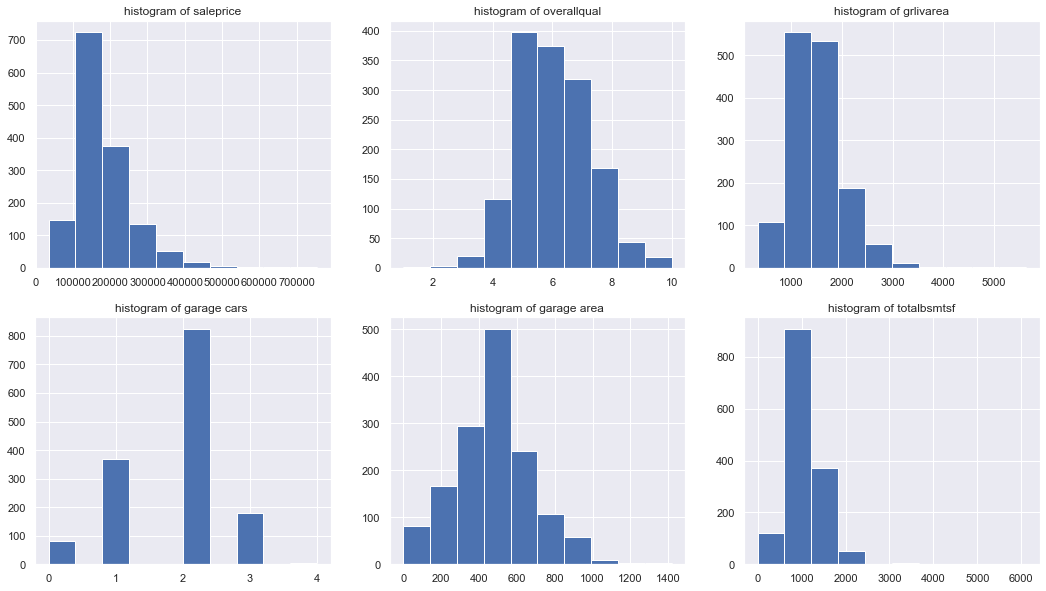

In [28]:
plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(house_prices_df["saleprice"])
plt.title("histogram of saleprice")

plt.subplot(2, 3, 2)
plt.hist(house_prices_df["overallqual"])
plt.title("histogram of overallqual")

plt.subplot(2, 3, 3)
plt.hist(house_prices_df["grlivarea"])
plt.title("histogram of grlivarea")


plt.subplot(2, 3, 4)
plt.hist(house_prices_df["garagecars"])
plt.title("histogram of garage cars ")

plt.subplot(2, 3, 5)
plt.hist(house_prices_df["garagearea"])
plt.title("histogram of garage area")

plt.subplot(2, 3, 6)
plt.hist(house_prices_df["totalbsmtsf"])
plt.title("histogram of totalbsmtsf")

plt.show()

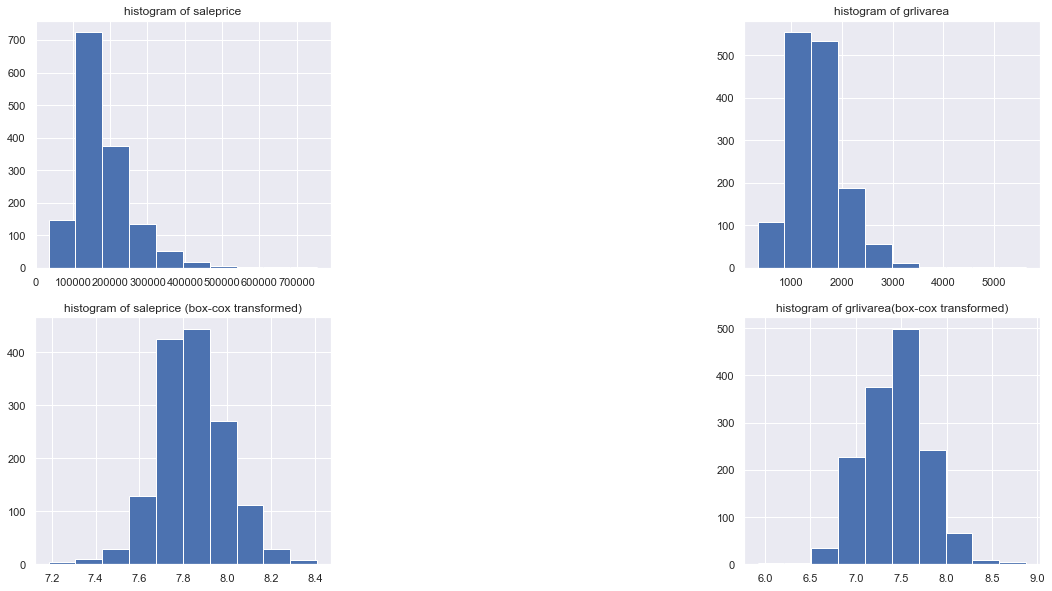

In [29]:
from scipy.stats import boxcox
# since box-cox transformation only works with positive data
# we are including only positive values.
saleprice_boxcox,_ = boxcox(house_prices_df["saleprice"])
overallqual_boxcox,_ = boxcox(house_prices_df["overallqual"])
grlivarea_boxcox,_ = boxcox(house_prices_df["grlivarea"])


plt.figure(figsize=(18,10))

plt.subplot(2, 3, 1)
plt.hist(house_prices_df["saleprice"])
plt.title("histogram of saleprice")

plt.subplot(2, 3, 3)
plt.hist(house_prices_df["grlivarea"])
plt.title("histogram of grlivarea")
                                                                               

plt.subplot(2, 3, 4)
plt.hist(saleprice_boxcox)
plt.title("histogram of saleprice (box-cox transformed)")


plt.subplot(2, 3, 6)
plt.hist(grlivarea_boxcox)
plt.title("histogram of grlivarea(box-cox transformed)")

plt.show()

In [30]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(house_prices_df["saleprice"])
norm_stats = normaltest(house_prices_df["saleprice"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(house_prices_df["overallqual"])
norm_stats = normaltest(house_prices_df["overallqual"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(house_prices_df["grlivarea"])
norm_stats = normaltest(house_prices_df["grlivarea"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(house_prices_df["grlivarea"])
norm_stats = normaltest(house_prices_df["grlivarea"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


jb_stats = jarque_bera(house_prices_df["garagecars"])
norm_stats = normaltest(house_prices_df["garagecars"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


jb_stats = jarque_bera(house_prices_df["garagearea"])
norm_stats = normaltest(house_prices_df["garagearea"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


jb_stats = jarque_bera(house_prices_df["totalbsmtsf"])
norm_stats = normaltest(house_prices_df["totalbsmtsf"])

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))



print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))



print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3438.8721241220583 and p value is 0.0
Normality test statistics is 610.8359109472653 and p value is 2.283848353787728e-133
Jarque-Bera test statistics is 11.94216442296766 and p value is 0.002551478684797881
Normality test statistics is 11.904563953541974 and p value is 0.002599900830568968
Jarque-Bera test statistics is 1898.7950810202435 and p value is 0.0
Normality test statistics is 437.12025688620975 and p value is 1.2037665001542135e-95
Jarque-Bera test statistics is 1898.7950810202435 and p value is 0.0
Normality test statistics is 437.12025688620975 and p value is 1.2037665001542135e-95
Jarque-Bera test statistics is 31.335806238894175 and p value is 1.5686141641158002e-07
Normality test statistics is 29.925269971844077 and p value is 3.1754859159754766e-07
Jarque-Bera test statistics is 58.22260036310695 and p value is 2.275957200481571e-13
Normality test statistics is 34.04138208798993 and p value is 4.055158198327377e-08
Jarque-Bera test statis

# Basic Model

In [94]:
# Y is the target variable
Y = house_prices_df[['saleprice']]
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     540.5
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        00:40:06   Log-Likelihood:                -13979.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1160   BIC:                         2.801e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.341e+05   9.54e+04     -6.647      0.000   -8.21e+05   -4.47e+05
overallqual  2.151e+04   1328.272     16.197      0.000    1.89e+04    2.41e+04
grlivarea      48.1407      2.960     16.264      0.000      42.333      53.948
garagecars   1.182e+04   3473.167      3.404      0.001    5008.085    1.86e+04
garagearea     17.7628     11.590      1.533      0.126      -4.977      40.503
totalbsmtsf    24.4502      3.217      7.599      0.000      18.138      30.763
lotfrontage    11.9203     55.446      0.215      0.830     -96.866     120.706
yearbuilt     281.3381     50.066      5.619      0.000     183.108     379.568
==============================================================================
Omnibus:                      415.474   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37607.202
Skew:                          -0.668   Prob(JB):                         0.00
Kurtosis:                      30.766   Cond. No.                     2.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our above R-squared score is 0.761 and the Adjusted R-squared score is 0.760 this is a well fits model. The R-squares are values are closed which means we've selected relevant features. Our F-test is 926.5 this is also know as the intercept only model. Meaning the F-test does not include features. Our p value is zero which is somthing we can accept, this also shows we have a positive relationship between all the features and the target variable. The AIC is 35010 and BIC is 35040

# Enchanced OLS Model

In [33]:
# second model with more features added.
# x = features
Y = house_prices_df[['saleprice']]
# target variable
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

X_const = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()



Coefficients: 
 [[2.05700950e+04 4.97856021e+01 1.02567544e+04 1.69379540e+01
  2.80330612e+01 6.87762753e+01 3.04700071e+02]]

Intercept: 
 [-681233.03370259]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     689.6
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:02:36   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1452   BIC:                         3.501e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.812e+05   8.49e+04     -8.023      0.000   -8.48e+05   -5.15e+05
overallqual  2.057e+04   1159.481     17.741      0.000    1.83e+04    2.28e+04
grlivarea      49.7856      2.627     18.954      0.000      44.633      54.938
garagecars   1.026e+04   3047.887      3.365      0.001    4278.022    1.62e+04
garagearea     16.9380     10.377      1.632      0.103      -3.417      37.293
totalbsmtsf    28.0331      2.950      9.502      0.000      22.246      33.820
lotfrontage    68.7763     51.113      1.346      0.179     -31.486     169.039
yearbuilt     304.7001     44.570      6.836      0.000     217.271     392.129
==============================================================================
Omnibus:                      475.801   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54968.513
Skew:                          -0.429   Prob(JB):                         0.00
Kurtosis:                      33.048   Cond. No.                     2.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Below is our R-squared score is 0.769 and the Adjusted R-squared score is 0.768 this is better than our first model. The R-squares are values are closed which means we've selected relevant features. Our F-test is 689.6 this is also know as the intercept only model. Meaning the F-test does not include features. Our p value is zero which is somthing we can accept, this also shows we have a positive relationship between all the features and the target variable. The AIC is 349700 and BIC is 350100 respectivetly.

In [35]:
house_prices_df2 = house_prices_df.copy()


Coefficients: 
 [2. 3.]

Intercept: 
 0.999999999650754


Text(0.5, 1.0, 'Linear regression can capture quadratic relationship')

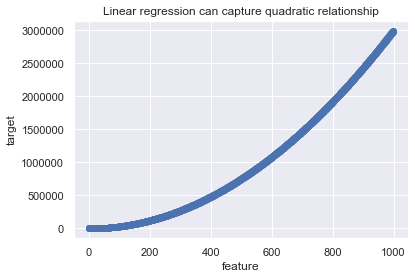

In [36]:
house_prices_df2 = pd.DataFrame()

# data from 0 to 999
house_prices_df2["X"] = np.arange(0,1000,1)
# we take the square of X
house_prices_df2["X_sq"] = house_prices_df2["X"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
house_prices_df2["Y"] = 1 + 2*house_prices_df2["X"] + 3*house_prices_df2["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(house_prices_df2[["X","X_sq"]],house_prices_df2["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(house_prices_df2[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(house_prices_df2["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')

In [37]:
# Assumption two: the error term should be zero on average and it shows that.
predictions = lrm.predict(X_const)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

Mean of the errors in the weather model is: saleprice   0.000
dtype: float64


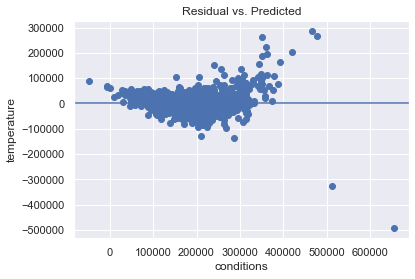

In [38]:
# Assumption three: homoscedasticity
plt.scatter(predictions, errors)
plt.xlabel('conditions')
plt.ylabel('temperature')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The realtionship above shows homoscedasticity because all data points is around the straight line and they are very close together.

In [39]:
#Assumption four: low multicollinearity
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({"vif": vif[0:]}, index=X.columns).T

,const,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,lotfrontage,yearbuilt
vif,7178.500,2.558,1.896,5.162,4.897,1.667,1.261,1.803


Above is the multicollinearity chart. The threshhold is 5 and below. currently all features have very low multicollinearity. Multicollinearity occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results.

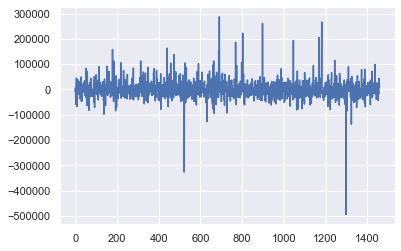

In [40]:
#Assumption five: error terms should be uncorrelated with one another
plt.plot(errors)
plt.show()

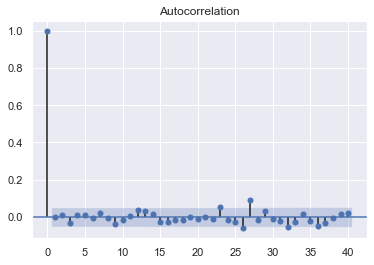

In [41]:
#No autocorrelation of risiduals
acf = smt.graphics.plot_acf(Y, lags=40 , alpha=0.05)
acf.show()

According to autiocorrelation most of the features are uncorrelated because most points do not sit directly on the line.

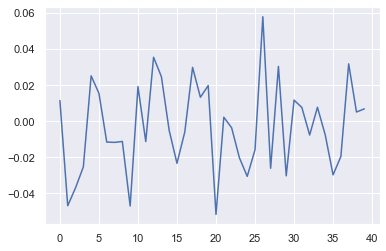

In [42]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

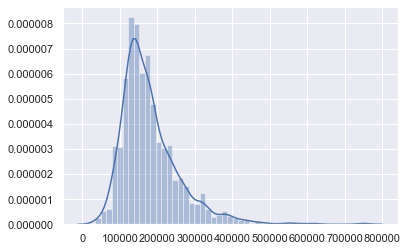

In [43]:
sns.distplot(Y)

In [44]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 54968.51263481827 and p value is 0.0
Normality test statistics is [475.8007292] and p value is [4.79937198e-104]


In [45]:
Y

,saleprice
0,208500
1,181500
2,223500
3,140000
4,250000
5,143000
6,307000
7,200000
8,129900
9,118000


In [46]:
X

,const,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,lotfrontage,yearbuilt
0,1.000,7,1710,2,548,856,65.000,2003
1,1.000,6,1262,2,460,1262,80.000,1976
2,1.000,7,1786,2,608,920,68.000,2001
3,1.000,7,1717,3,642,756,60.000,1915
4,1.000,8,2198,3,836,1145,84.000,2000
5,1.000,5,1362,2,480,796,85.000,1993
6,1.000,8,1694,2,636,1686,75.000,2004
7,1.000,7,2090,2,484,1107,70.050,1973
8,1.000,7,1774,2,468,952,51.000,1931
9,1.000,5,1077,1,205,991,50.000,1939


# 3) Now, split your data into train and test sets where 20% of the data resides in the test set.

In [47]:
Y = house_prices_df[['saleprice']]

X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

#X_const = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     540.5
Date:                Thu, 30 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:06:33   Log-Likelihood:                -13979.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1160   BIC:                         2.801e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.341e+05   9.54e+04     -6.647      0.000   -8.21e+05   -4.47e+05
overallqual  2.151e+04   1328.272     16.197      0.000    1.89e+04    2.41e+04
grlivarea      48.1407      2.960     16.264      0.000      42.333      53.948
garagecars   1.182e+04   3473.167      3.404      0.001    5008.085    1.86e+04
garagearea     17.7628     11.590      1.533      0.126      -4.977      40.503
totalbsmtsf    24.4502      3.217      7.599      0.000      18.138      30.763
lotfrontage    11.9203     55.446      0.215      0.830     -96.866     120.706
yearbuilt     281.3381     50.066      5.619      0.000     183.108     379.568
==============================================================================
Omnibus:                      415.474   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37607.202
Skew:                          -0.668   Prob(JB):                         0.00
Kurtosis:                      30.766   Cond. No.                     2.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

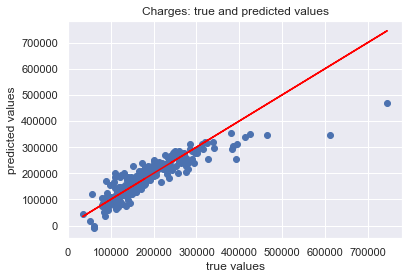

Mean absolute error of the prediction is: 25167.15096605375
Mean squared error of the prediction is: [6.74348432e+09 4.25797501e+10 6.76610039e+09 9.78891859e+09
 1.90486873e+10 6.71998312e+09 1.08048135e+10 2.39766392e+10
 7.38486056e+09 3.53601945e+10 1.40441503e+10 6.72817963e+09
 1.56047769e+10 2.11554535e+10 1.07042803e+10 1.71483772e+10
 6.78660475e+09 7.11814143e+09 7.51014808e+09 6.78755477e+09
 3.33387092e+10 7.90618665e+09 6.74253262e+09 2.32397338e+10
 8.33671350e+09 6.80947066e+09 7.41080603e+09 7.24173124e+09
 6.85056526e+09 8.78853649e+10 1.06969147e+10 9.98829583e+09
 8.05835033e+09 2.09142642e+10 7.60279911e+09 1.44749448e+10
 1.68927097e+10 7.70977958e+09 8.48529666e+09 2.88288989e+10
 8.05124965e+09 7.22812532e+09 9.66201515e+09 6.84827801e+09
 7.69210030e+09 7.32127139e+09 9.28379485e+09 1.46101783e+10
 1.52441968e+10 1.06801255e+10 6.94430921e+09 7.82298590e+09
 6.81190804e+09 9.68135749e+09 7.90230420e+09 7.53400572e+09
 7.50544592e+09 1.71979190e+10 3.37356652e+10

In [48]:
# We are making predictions here
Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

# 4) Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

In [49]:
Y = house_prices_df[['saleprice']]

X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lrm = LinearRegression()
lrm.fit(X_train, Y_train)

#We are making predictions here
Y_preds_train = lrm.predict(X_train)
Y_preds_test = lrm.predict(X_test)


print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.7653470226547674
-----Test set statistics-----
R-squared of the model in the test set is: 0.7770444997927131
Mean absolute error of the prediction is: 25167.15096605314
Mean squared error of the prediction is: [1.49685725e+09]
Root mean squared error of the prediction is: [38689.23947551]
Mean absolute percentage error of the prediction is: saleprice   15.321
dtype: float64


In [50]:
from sklearn.linear_model import Ridge


ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = ridge_cv.predict(X_train)
Y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(ridge_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(ridge_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in the training set is: 0.765329547751796
-----Test set statistics-----
R-squared of the model in the test set is: 0.777482360243966
Mean absolute error of the prediction is: 25094.58160566741
Mean squared error of the prediction is: [1.49391759e+09]
Root mean squared error of the prediction is: [38651.23006705]
Mean absolute percentage error of the prediction is: saleprice   15.263
dtype: float64


In [51]:
from sklearn.linear_model import ElasticNet

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, Y_train)

# We are making predictions here
Y = elasticnet_cv.predict(X_train)
Y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(elasticnet_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elasticnet_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


Best alpha value is: 0.01
R-squared of the model in the training set is: 0.7653408164602349
-----Test set statistics-----
R-squared of the model in the test set is: 0.7773073784953669
Mean absolute error of the prediction is: 25124.245769097124
Mean squared error of the prediction is: [6.74363507e+09 4.25408535e+10 6.76393336e+09 9.76748643e+09
 1.90343584e+10 6.71944180e+09 1.07787261e+10 2.39051530e+10
 7.38254473e+09 3.52672133e+10 1.40145573e+10 6.72875222e+09
 1.56387034e+10 2.11554314e+10 1.06823034e+10 1.71178184e+10
 6.78840555e+09 7.12164134e+09 7.51753210e+09 6.78728710e+09
 3.32942578e+10 7.90391618e+09 6.73984018e+09 2.32646809e+10
 8.35933865e+09 6.80769938e+09 7.39941617e+09 7.23813835e+09
 6.85033834e+09 8.79090609e+10 1.07468725e+10 9.98118064e+09
 8.05009976e+09 2.08629876e+10 7.59352924e+09 1.44857378e+10
 1.68587157e+10 7.72131798e+09 8.49418085e+09 2.88147644e+10
 8.05308759e+09 7.23701866e+09 9.64992573e+09 6.85111734e+09
 7.70329885e+09 7.31303607e+09 9.27799643e+

ValueError: Unable to coerce to Series, length must be 1: given 292

# 5) Evaluate your best model on the test set.

From our evaluation is turns out that the reidge regression has the highest R-test score of 7774. About 78% percent.

# 6) So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

collected gdp in the first quarter from year 2006-2010 at https://fred.stlouisfed.org/series/A191RL1Q225SBEA
collected unemployment in December from year 2006-2010 https://fred.stlouisfed.org/series/UNRATE

In [86]:
unemployment_rate = [4.4, 5.0,7.3, 9.9,9.3]
gdp_rate = [5.4, 0.9,-2.3,-4.4,1.5]

def unemployment(row):
   if row["yrsold"] == 2006 :
      return 4.4
   if row["yrsold"] == 2007 :
      return 5.0
   if row["yrsold"] == 2008:
      return 7.3
   if row["yrsold"]  == 2009:
      return 9.9
   if row["yrsold"] == 2010:
      return 9.3
house_prices_df["unemployment_rate"]=house_prices_df.apply (lambda row: unemployment(row), axis=1)

In [87]:
def gdp_rate(row):
   if row["yrsold"] == 2006 :
      return 5.4
   if row["yrsold"] == 2007 :
      return 0.9
   if row["yrsold"] == 2008:
      return -2.3
   if row["yrsold"]  == 2009:
      return -4.4
   if row["yrsold"] == 2010:
      return 1.5
house_prices_df["gdp_rate"]=house_prices_df.apply (lambda row: gdp_rate(row), axis=1)

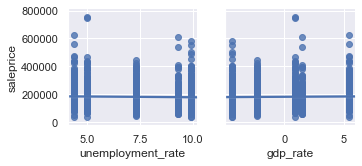

In [88]:
s = sns.pairplot(data=house_prices_df,
            y_vars = 'saleprice',
            x_vars = ["unemployment_rate", "gdp_rate"],kind='reg')

saleprice is much higher with less unemployment rate and gdp the sale price seems higher if gdp is around 0. We also see as gdp is higher sale price is lower. We will first see if it has any affect on our normal model.

# Basic Model with two new variables

In [95]:
Y = house_prices_df[['saleprice']]

X = house_prices_df[['unemployment_rate', 'gdp_rate','overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

#X_const = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(Y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     419.8
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        00:41:34   Log-Likelihood:                -13979.
No. Observations:                1168   AIC:                         2.798e+04
Df Residuals:                    1158   BIC:                         2.803e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -6.36e+05   9.56e+04     -6.653      0.000   -8.24e+05   -4.48e+05
unemployment_rate   203.7986    816.156      0.250      0.803   -1397.511    1805.108
gdp_rate            -27.5163    516.384     -0.053      0.958   -1040.668     985.636
overallqual        2.151e+04   1329.709     16.175      0.000    1.89e+04    2.41e+04
grlivarea            48.1986      2.965     16.258      0.000      42.382      54.015
garagecars         1.188e+04   3479.234      3.416      0.001    5057.515    1.87e+04
garagearea           17.5856     11.608      1.515      0.130      -5.190      40.361
totalbsmtsf          24.4582      3.220      7.595      0.000      18.140      30.776
lotfrontage          11.2954     55.523      0.203      0.839     -97.641     120.232
yearbuilt           281.5431     50.116      5.618      0.000     183.215     379.871
==============================================================================
Omnibus:                      415.441   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37629.583
Skew:                          -0.667   Prob(JB):                         0.00
Kurtosis:                      30.775   Cond. No.                     2.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On our regular model result shows:
our R-squared and adjusted R-squared did not improve 
We see our F-score went down from 540 to 419

# Enhanced Model with two new variabless

In [93]:
# second model with more features added.
# x = features
Y = house_prices_df[['saleprice']]
# target variable
X = house_prices_df[['unemployment_rate', 'gdp_rate','overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

X_const = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf', 'lotfrontage','yearbuilt']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()



Coefficients: 
 [[2.08155769e+02 1.99156778e+02 2.05800163e+04 4.97807350e+01
  1.02290936e+04 1.70663848e+01 2.80326064e+01 6.84513836e+01
  3.04220802e+02]]

Intercept: 
 [-681796.29593103]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     535.7
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        00:37:12   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1450   BIC:                         3.502e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6.818e+05    8.5e+04     -8.017      0.000   -8.49e+05   -5.15e+05
unemployment_rate   208.1558    724.166      0.287      0.774   -1212.370    1628.682
gdp_rate            199.1568    459.447      0.433      0.665    -702.095    1100.408
overallqual        2.058e+04   1160.422     17.735      0.000    1.83e+04    2.29e+04
grlivarea            49.7807      2.629     18.933      0.000      44.623      54.938
garagecars         1.023e+04   3051.080      3.353      0.001    4244.091    1.62e+04
garagearea           17.0664     10.388      1.643      0.101      -3.311      37.444
totalbsmtsf          28.0326      2.952      9.496      0.000      22.242      33.823
lotfrontage          68.4514     51.155      1.338      0.181     -31.894     168.796
yearbuilt           304.2208     44.612      6.819      0.000     216.710     391.732
==============================================================================
Omnibus:                      475.052   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54708.738
Skew:                          -0.427   Prob(JB):                         0.00
Kurtosis:                      32.977   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In our enhanced model Adjusted R-squared went down by 1 point 
and F score went down from 689.6 to 535.7
Both AIC remained the same at 3.497e+04. Our original Enhanced OLS model did a better job than the model with the two new variables. Next we will try this model with Ridge regression because it had the highest accuracy, finally we will try elastic net on this model.

In [96]:
from sklearn.linear_model import Ridge


ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, Y_train)

# We are making predictions here
Y_preds_train = ridge_cv.predict(X_train)
Y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(ridge_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(ridge_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in the training set is: 0.765374967788365
-----Test set statistics-----
R-squared of the model in the test set is: 0.7769940034174283
Mean absolute error of the prediction is: 25148.41001991356
Mean squared error of the prediction is: [1.49719627e+09]
Root mean squared error of the prediction is: [38693.62051959]
Mean absolute percentage error of the prediction is: saleprice   15.296
dtype: float64


In [97]:
from sklearn.linear_model import ElasticNet

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, Y_train)

# We are making predictions here
Y = elasticnet_cv.predict(X_train)
Y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in the training set is: {}".format(elasticnet_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(elasticnet_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds_test) / Y_test)) * 100))


Best alpha value is: 0.01
R-squared of the model in the training set is: 0.7653863203524258
-----Test set statistics-----
R-squared of the model in the test set is: 0.7768136991604
Mean absolute error of the prediction is: 25178.591137884887
Mean squared error of the prediction is: [6.75105749e+09 4.22977023e+10 6.77429965e+09 9.81395244e+09
 1.88926335e+10 6.71675850e+09 1.07689082e+10 2.40281626e+10
 7.42135371e+09 3.51470757e+10 1.39075932e+10 6.73443632e+09
 1.55567737e+10 2.09969037e+10 1.06742310e+10 1.72805239e+10
 6.77645543e+09 7.13778825e+09 7.55747311e+09 6.80040927e+09
 3.34459644e+10 7.93310468e+09 6.73337187e+09 2.31712879e+10
 8.30508879e+09 6.82262755e+09 7.37791789e+09 7.21844296e+09
 6.86606704e+09 8.77322940e+10 1.06925493e+10 9.93201273e+09
 8.10275580e+09 2.07058844e+10 7.63490383e+09 1.46094109e+10
 1.67262814e+10 7.67804772e+09 8.55612336e+09 2.89648354e+10
 8.04731044e+09 7.23138198e+09 9.60368283e+09 6.86750449e+09
 7.69654302e+09 7.30550524e+09 9.32287528e+09 

ValueError: Unable to coerce to Series, length must be 1: given 292

We were able to use external features and alter the dataframe to which did not improve our the model, we actually received less accurate result. Overall the original Ridge regression had the highest accuracy and R value of 0.777.

In Summary we:


Loaded the houseprices data from Thinkful's database.
Did data cleaning, exploratory data analysis, and feature engineering.
split the data into train and test sets where 20% of the data resides in the test set.
Built several linear regression models including Ridge and ElasticNet and trained them in the training set. Used k-fold cross-validation to select the best hyperparameters.
Evaluated the best model on the test set.
We added a few factors that were not included in the dataset. Integrated these factors into the model and attempted to enhanced the prediction performance of the model, unfortunately this was not successful in improving our model.